# Part 1: Building an Item-Item Recommender
If you use Netflix, you will notice that there is a section titled "Because you watched Movie X", which provides recommendations for movies based on a recent movie that you've watched. This is a classic example of an item-item recommendation.

In this tutorial, we will generate item-item recommendations using a technique called <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">collaborative filtering</a>. Let's get started!

### Step 1: Import the Dependencies
We will be representing our data as a pandas DataFrame.

What is a DataFrame?

- a two-dimensional Pandas data structure
- columns represent features, rows represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

We will also be using two plotting packages: matplotlib and seaborn (which is a wrapper of matplotlib) to visualize our data.

In [23]:
import pandas as pd
import numpy as np
import ast
import time

### Step 2: Load the Data 

Let's download a small version of the MovieLens dataset. You can access it via the zip file url here, or directly download here. We're working with data in ml-latest-small.zip and will need to add the following files to our local directory:

- ratings.csv
- movies.csv
These are also located in the data folder inside this GitHub repository.

Alternatively, you can access the data here:

- https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv
- https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv

Let's load in our data and take a peek at the structure.

In [24]:
ratings = pd.read_csv("../data/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [25]:
ratings.shape

(100004, 4)

In [26]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [27]:
movies = pd.read_csv("../data/movies.csv")
movies.head()

,genres,id,original_title,popularity,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,21.946943,1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,17.015539,1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,3.859495,1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,8.387519,1995-02-10


In [28]:
movies.shape

(45466, 5)

In [29]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   genres          45466 non-null  object
 1   id              45466 non-null  object
 2   original_title  45466 non-null  object
 3   popularity      45461 non-null  object
 4   release_date    45379 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


### Step 3: Data pre-processing
In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains user's ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

In [30]:
movies = (movies
          # Alternative : .drop(movies[~movies['id'].str.isnumeric()].index)
          .drop_duplicates(subset=['original_title'])
          .dropna()
          .astype({'id': np.int64})
         )
movies.head()

,genres,id,original_title,popularity,release_date
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,Toy Story,21.946943,1995-10-30
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,Jumanji,17.015539,1995-12-15
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,Waiting to Exhale,3.859495,1995-12-22
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Father of the Bride Part II,8.387519,1995-02-10


In [31]:
movie_genres = []
for line in movies['genres']:
    line = ast.literal_eval(line)
    list_comp = [element['name'] for element in line]
    movie_genres.append(list_comp)
    
movies['genres'] = movie_genres
movies.head()

,genres,id,original_title,popularity,release_date
0,"[Animation, Comedy, Family]",862,Toy Story,21.946943,1995-10-30
1,"[Adventure, Fantasy, Family]",8844,Jumanji,17.015539,1995-12-15
2,"[Romance, Comedy]",15602,Grumpier Old Men,11.7129,1995-12-22
3,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,3.859495,1995-12-22
4,[Comedy],11862,Father of the Bride Part II,8.387519,1995-02-10


In [32]:
movies.shape

(43287, 5)

In [33]:
ratings = (ratings
           .join(movies.set_index('id')['original_title'], on='movieId')
           .dropna())
ratings.head()

,userId,movieId,rating,timestamp,original_title
10,1,1371,2.5,1260759135,Rocky III
11,1,1405,1.0,1260759203,Greed
13,1,2105,4.0,1260759139,American Pie
15,1,2193,2.0,1260759198,My Tutor
16,1,2294,2.0,1260759108,Jay and Silent Bob Strike Back


In [34]:
ratings.shape

(43322, 5)

### Step 4: Exploratory Data Analysis
In Part 1 of this tutorial series, we will focus on the `ratings` dataset. We'll need `movies` for subsequent sections. `Ratings` contains user's ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

### Step 5: Transforming the data
We will be using a technique called <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">collaborative filtering</a> to generate user recommendations. This technique is based on the assumption of "homophily" - similar users like similar things. Collaborative filtering is a type of unsupervised learning that makes predictions about the interests of a user by learning from the interests of a larger population.

The first step of collaborative filtering is to transform our data into a `user-item matrix` - also known as a "utility" matrix. In this matrix, rows represent users and columns represent items. The beauty of collaborative filtering is that it doesn't require any information about the users or items to generate recommendations.

<div>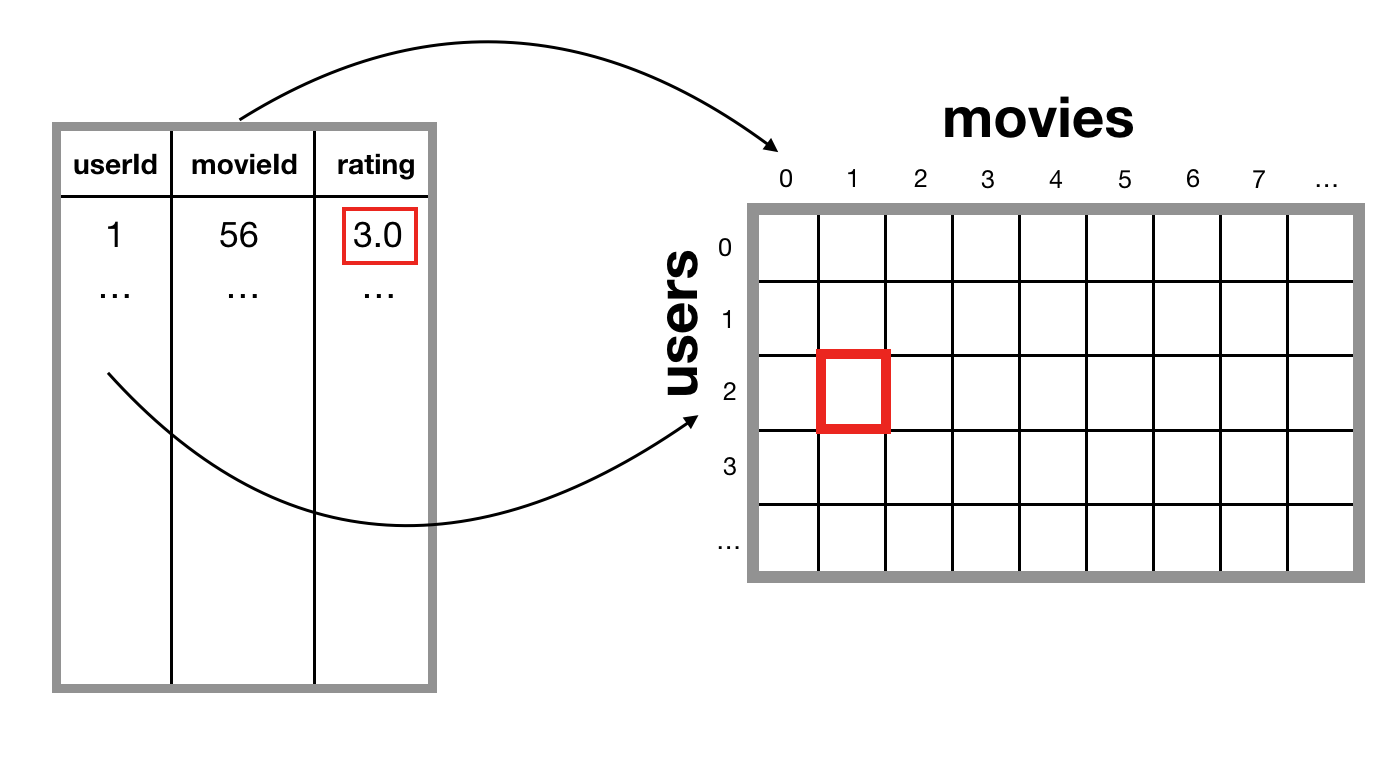</div>

The create_X() function outputs a sparse matrix X with four mapper dictionaries:
- user_mapper: maps user id to user index
- movie_mapper: maps movie id to movie index
- user_inv_mapper: maps user index to user id
- movie_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

The X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [35]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        movie_mapper: dict that maps movie id's to movie indices
    """
        
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(df['movieId'].nunique()))))
    movie_inv_mapper = dict(zip(list(range(df['movieId'].nunique())), np.unique(df["movieId"])))
        
    df = (df
          .pivot(index='movieId', columns='userId', values='rating')
          .fillna(0)
         )

    X = csr_matrix(df.values)
    
    return X, movie_mapper, movie_inv_mapper

In [36]:
X, movie_mapper, movie_inv_mapper = create_X(ratings)

Let's check out the sparsity of our X matrix.

Here, we calculate sparsity by dividing the number of non-zero elements by total number of elements as described in the equation below: 

$$S=\frac{\text{# non-zero elements}}{\text{total elements}}$$

In [37]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 2.37%


Only 2.37% of cells in our user-item matrix are populated with ratings. But don't be discouraged by this sparsity! User-item matrices are typically very sparse. A general rule of thumb is that your matrix sparsity should be no lower than 0.5% to generate decent results.

<div>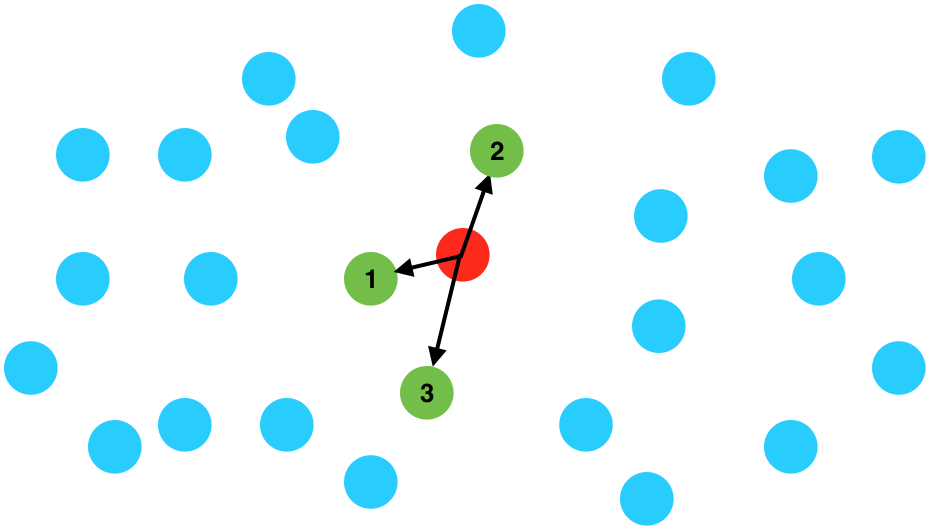</div>

## Step 6: Finding similar movies using k-Nearest Neighbours

This approach looks for the $k$ nearest neighbours of a given movie by identifying $k$ points in the dataset that are closest to movie $m$. kNN makes use of distance metrics such as:

1. Cosine similarity
2. Euclidean distance
3. Manhattan distance
4. Pearson correlation 

Although difficult to visualize, we are working in a M-dimensional space where M represents the number of movies in our X matrix. 

In [38]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    X = X.T
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    movie_vec = movie_vec.reshape(1,-1)
    
    k+=1

    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    neighbour_ids = [movie_inv_mapper[neighbour.item(i)] for i in range(1, k)]
    
    return neighbour_ids

`find_similar_movies()` takes in a movieId and user-item X matrix, and outputs a list of $k$ movies that are similar to the movieId of interest. 

Let's see how it works in action. We will first create another mapper that maps `movieId` to `title` so that our results are interpretable. 

In [39]:
movie_titles = dict(zip(ratings['movieId'], ratings['original_title']))

movie_id = 455

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Bend It Like Beckham
Pickpocket
七人の侍
Sommer '04
Blood: The Last Vampire
Street Kings
Some Like It Hot
Forbidden Planet
Dune
The Thing
Harry Potter and the Goblet of Fire


The results above show the 10 most similar movies to Toy Story. Most movies in this list are family movies from the 1990s, which seems pretty reasonable. Note that these recommendations are based solely on user-item ratings. Movie features such as genres are not taken into consideration in this approach.

You can also play around with the kNN distance metric and see what results you would get if you use "manhattan" or "euclidean" instead of "cosine".

In [40]:
movie_titles = dict(zip(ratings['movieId'], ratings['original_title']))

movie_id = 455

similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Bend It Like Beckham
Pickpocket
Street Kings
Don't Look Now
A Close Shave
Diamonds Are Forever
Die Blechtrommel
Ariel
Shaft in Africa
Catwoman
Shrek


### Step 7: Dimensionality Reduction with Matrix Factorization (advanced)

Matrix factorization (MF) is a linear algebra technique that can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. MF is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like romantic comedies from the 1990s, while another latent feature may represent movies which are independent foreign language films.

$$X_{mn}\approx P_{mk}\times Q_{nk}^T = \hat{X} $$

<div>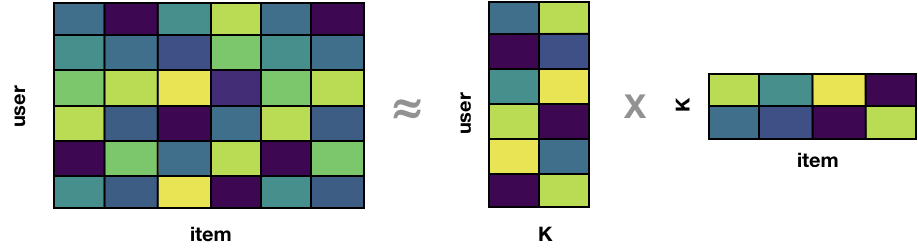</div>

In [41]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=10)
Z = svd.fit_transform(X.T)

In [42]:
movie_id = 455
similar_movies = find_similar_movies(movie_id, Z.T, k=10, metric="cosine")
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Bend It Like Beckham:
Halloween
All the President's Men
Charlie and the Chocolate Factory
Eyes Wide Shut
The Mask
2046
Manhattan
Trois couleurs : Bleu
Caché
Murder She Said


### Step 8: Evaluation

How do we know if our recommendations are good? The best way to evaluate our system is to test it in the wild with A/B testing or usability tests, where we can get direct feedback from users. However, this option is not always available which means that we need to use offline metrics. 

In traditional machine learning, we evaluate a model by splitting our data into two sets: 1) `training set` and 2) `validation set`. We train our model using the `training set`, then test our model on the `validation set`. In recommender systems, we can't split our data the traditional way because our model won't work if our training set represents a completely different user population than the validation set. Instead, we generate our `training set` by masking random interactions in our user-item matrix. In other words, we pretend that we don't if a user liked or hated Movie X, but we actually do. Once we train our model and generate our rating predictions, we can then compare our predicted rating with the actual rating. 

<div>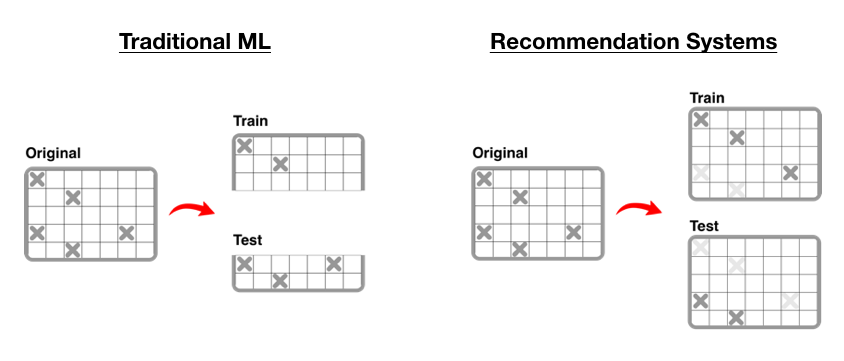</div>

There are various ways to compare our predicted vs. actual ratings. The most common metrics include:
    
1) Root Mean Squared Error: $\text{RMSE} = \sqrt{\frac{\Sigma^N_{i=1}(y-\hat{y})^2}{N}}$

2) Precision: $\text{Precision} = \frac{TP}{TP+FP}$

3) Recall: $\text{Recall} = \frac{TP}{TP+FN}$